<a href="https://colab.research.google.com/github/desaishivani/Classify-Song-Genres-from-Audio-Data/blob/main/DSBA_6156_Classify_Song_Genre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# **1. Preparing our dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read in track metadata with genre labels
##tracks = pd.read_csv("/content/drive/MyDrive/fma-rock-vs-hiphop.csv")
tracks = pd.read_csv("/content/drive/MyDrive/6156-Applied Machine Learning/Group project DSBA 6156/fma-rock-vs-hiphop.csv")
# Read in track metrics with the features
##echonest_metrics = pd.read_json("/content/drive/MyDrive/echonest-metrics.csv", precise_float=True)
echonest_metrics = pd.read_json("/content/drive/MyDrive/6156-Applied Machine Learning/Group project DSBA 6156/echonest-metrics.csv", precise_float=True)
# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = pd.merge(left= tracks[['track_id', 'genre_top']], right=echonest_metrics, on='track_id')


# Inspect the resultant dataframe
echo_tracks.head()

,track_id,genre_top,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,153,Rock,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018
1,154,Rock,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758,0.035632
2,155,Rock,0.981657,0.142249,0.912122,0.967294,0.363510,0.087527,91.912,0.034325
3,169,Rock,0.989141,0.225978,0.722835,0.263076,0.092371,0.053406,94.322,0.028347
4,170,Rock,0.886660,0.298518,0.744333,0.920950,0.139587,0.088781,97.880,0.073548


In [ ]:
echo_tracks.isnull().sum()

track_id            0
genre_top           0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
speechiness         0
tempo               0
valence             0
dtype: int64

In [ ]:
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   genre_top         4802 non-null   object 
 2   acousticness      4802 non-null   float64
 3   danceability      4802 non-null   float64
 4   energy            4802 non-null   float64
 5   instrumentalness  4802 non-null   float64
 6   liveness          4802 non-null   float64
 7   speechiness       4802 non-null   float64
 8   tempo             4802 non-null   float64
 9   valence           4802 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


# **2. Pairwise relationships between continuous variables**

In [ ]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

<ipython-input-6-48e94c368ccc>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_metrics = echo_tracks.corr()


,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


# **3. Splitting our data**

In [ ]:
# Create features
features = echo_tracks.drop(['genre_top', 'track_id'], axis=1)

# Create labels
labels = echo_tracks[['genre_top']]

features.info()
labels.info()

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      4802 non-null   float64
 1   danceability      4802 non-null   float64
 2   energy            4802 non-null   float64
 3   instrumentalness  4802 non-null   float64
 4   liveness          4802 non-null   float64
 5   speechiness       4802 non-null   float64
 6   tempo             4802 non-null   float64
 7   valence           4802 non-null   float64
dtypes: float64(8)
memory usage: 337.6 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   genre_top  4802 non-null   object
dtypes: object(1)
memory usage: 75.0+ KB


In [ ]:
labels.value_counts()

genre_top
Rock         3892
Hip-Hop       910
dtype: int64

#**4. Normalizing the feature data**

In [ ]:
# Scale the features and set the values to a new variable
scaler = StandardScaler()

# Scale train_features and test_features
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

#**5. Principal Component Analysis on our scaled data.**

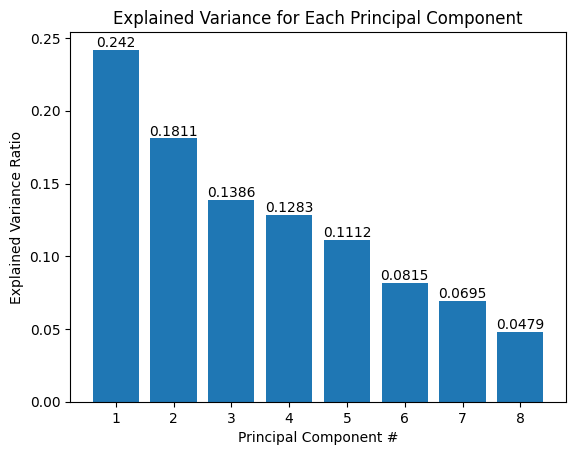

In [ ]:
%matplotlib inline
# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)

exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
bars = ax.bar(range(1, len(exp_variance) + 1), exp_variance)

# Add annotations for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

ax.set_xlabel('Principal Component #')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Explained Variance for Each Principal Component')
plt.show()


#**6. Further visualization of PCA.**

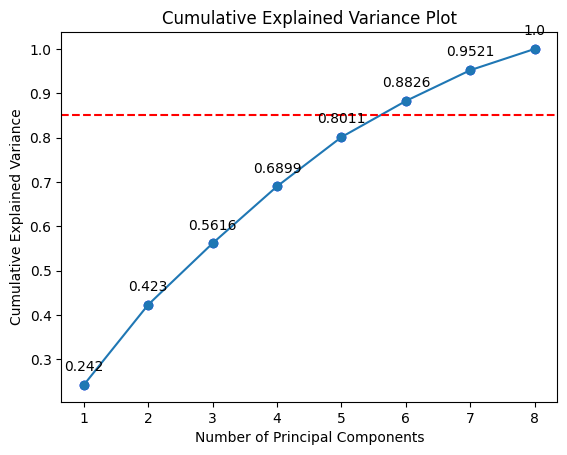

In [ ]:
# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(range(1, len(cum_exp_variance) + 1), cum_exp_variance, marker='o', linestyle='-')
ax.axhline(y=0.85, linestyle='--', color='red')

# Add individual markers for each point
ax.scatter(range(1, len(cum_exp_variance) + 1), cum_exp_variance, color='blue')

for i, txt in enumerate(cum_exp_variance):
    ax.annotate(round(txt, 4), (i+1, txt), textcoords="offset points", xytext=(0,10), ha='center')
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Cumulative Explained Variance')
ax.set_title('Cumulative Explained Variance Plot')
plt.show()


The point where the cumulative explained variance curve crosses the red dashed line is a suitable number of principal components to retain for explaining at least 85% of the variance in the data.


#**7. Projecting on to our features.**

In [ ]:
# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components=6,random_state=10)

# Fit and transform the scaled training features using pca
train_pca = pca.fit_transform(scaled_train_features)

# Fit and transform the scaled test features using pca
test_pca = pca.transform(scaled_test_features)

In [ ]:
train_pca.shape

(3601, 6)

In [ ]:
test_pca.shape

(1201, 6)

#**8. Train a decision tree to classify genre.**


In [ ]:
# Train our decision tree
tree = DecisionTreeClassifier(random_state=10, max_depth=10)
tree.fit(train_pca, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_pca)

In [ ]:
# Generate the classification report
report_tree = classification_report(test_labels, pred_labels_tree)

# Display the report
print("Classification Report for Decision Tree:")
print(report_tree)

Classification Report for Decision Tree:
              precision    recall  f1-score   support

     Hip-Hop       0.71      0.63      0.67       229
        Rock       0.91      0.94      0.93       972

    accuracy                           0.88      1201
   macro avg       0.81      0.78      0.80      1201
weighted avg       0.88      0.88      0.88      1201



In [ ]:
# Define the parameter grid for Decision Tree
tree_param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=10)

# GridSearchCV for Decision Tree
tree_grid_search = GridSearchCV(estimator=decision_tree, param_grid=tree_param_grid,
                                cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the GridSearchCV on the training data
tree_grid_search.fit(train_pca, train_labels.values.ravel())

# Print the best parameters and corresponding accuracy
print("Best Parameters for Decision Tree: ", tree_grid_search.best_params_)
print("Best Accuracy for Decision Tree: ", tree_grid_search.best_score_)

# Best model for Decision Tree
best_tree_model = tree_grid_search.best_estimator_

# Predictions on the test set using the best Decision Tree model
best_tree_predictions = best_tree_model.predict(test_pca)

# Evaluate the best Decision Tree model
best_tree_accuracy = accuracy_score(test_labels, best_tree_predictions)
best_tree_report = classification_report(test_labels, best_tree_predictions)

print(f"\nBest Model Accuracy for Decision Tree: {best_tree_accuracy}")
print("\nBest Model Classification Report for Decision Tree:\n", best_tree_report)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Best Parameters for Decision Tree:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Accuracy for Decision Tree:  0.8733703395318715

Best Model Accuracy for Decision Tree: 0.8776019983347211

Best Model Classification Report for Decision Tree:
               precision    recall  f1-score   support

     Hip-Hop       0.71      0.61      0.66       229
        Rock       0.91      0.94      0.93       972

    accuracy                           0.88      1201
   macro avg       0.81      0.78      0.79      1201
weighted avg       0.87      0.88      0.87      1201



Before PCA

In [ ]:
# Define the parameter grid for Decision Tree
tree_param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=10)

# GridSearchCV for Decision Tree
tree_grid_search = GridSearchCV(estimator=decision_tree, param_grid=tree_param_grid,
                                cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the GridSearchCV on the training data
tree_grid_search.fit(train_features, train_labels.values.ravel())

# Print the best parameters and corresponding accuracy
print("Best Parameters for Decision Tree: ", tree_grid_search.best_params_)
print("Best Accuracy for Decision Tree: ", tree_grid_search.best_score_)

# Best model for Decision Tree
best_tree_model = tree_grid_search.best_estimator_

# Predictions on the test set using the best Decision Tree model
best_tree_predictions = best_tree_model.predict(test_features)

# Evaluate the best Decision Tree model
best_tree_accuracy_1 = accuracy_score(test_labels, best_tree_predictions)
best_tree_report_1= classification_report(test_labels, best_tree_predictions)

print(f"\nBest Model Accuracy for Decision Tree: {best_tree_accuracy_1}")
print("\nBest Model Classification Report for Decision Tree:\n", best_tree_report_1)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Best Parameters for Decision Tree:  {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Accuracy for Decision Tree:  0.9036390970487557

Best Model Accuracy for Decision Tree: 0.8934221482098251

Best Model Classification Report for Decision Tree:
               precision    recall  f1-score   support

     Hip-Hop       0.76      0.65      0.70       229
        Rock       0.92      0.95      0.94       972

    accuracy                           0.89      1201
   macro avg       0.84      0.80      0.82      1201
weighted avg       0.89      0.89      0.89      1201



#**9. Logistic Regression.**


In [ ]:
log_reg = LogisticRegression(random_state=10)
log_reg.fit(train_pca, train_labels)

# Predict the labels for the test data
pred_labels_lg = log_reg.predict(test_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Generate the classification report
report_lg = classification_report(test_labels, pred_labels_lg)

# Display the report
print("Classification Report for Logistic Regression:")
print(report_lg)

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

     Hip-Hop       0.75      0.51      0.61       229
        Rock       0.89      0.96      0.93       972

    accuracy                           0.87      1201
   macro avg       0.82      0.74      0.77      1201
weighted avg       0.87      0.87      0.86      1201



In [ ]:
# Parameters for grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

log_reg = LogisticRegression(random_state=10)

# GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the GridSearchCV on the training data
grid_search.fit(train_pca, train_labels.values.ravel())

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

# Best model
best_lg_model = grid_search.best_estimator_

# Predictions on the test set using the best model
best_predictions = best_lg_model.predict(test_pca)

# Evaluate the best model
best_accuracy = accuracy_score(test_labels, best_predictions)
best_report = classification_report(test_labels, best_predictions)

print(f"\nBest Model Accuracy for Logistic Regression: {best_accuracy}")
print("\nBest Model Classification Report for Logistic Regression:\n", best_report)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters:  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best Accuracy:  0.8794796003330557

Best Model Accuracy for Logistic Regression: 0.8784346378018318

Best Model Classification Report for Logistic Regression:
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.51      0.62       229
        Rock       0.89      0.97      0.93       972

    accuracy                           0.88      1201
   macro avg       0.83      0.74      0.77      1201
weighted avg       0.87      0.88      0.87      1201



In [ ]:
# Parameters for grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

log_reg = LogisticRegression(random_state=10)

# GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the GridSearchCV on the training data
grid_search.fit(train_features, train_labels.values.ravel())

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

# Best model
best_lg_model_1 = grid_search.best_estimator_

# Predictions on the test set using the best model
best_predictions_1 = best_lg_model_1.predict(test_features)

# Evaluate the best model
best_accuracy = accuracy_score(test_labels, best_predictions_1)
best_report = classification_report(test_labels, best_predictions_1)

print(f"\nBest Model Accuracy for Logistic Regression: {best_accuracy}")
print("\nBest Model Classification Report for Logistic Regression:\n", best_report)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters:  {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best Accuracy:  0.8925309926912757

Best Model Accuracy for Logistic Regression: 0.8884263114071607

Best Model Classification Report for Logistic Regression:
               precision    recall  f1-score   support

     Hip-Hop       0.79      0.57      0.66       229
        Rock       0.90      0.96      0.93       972

    accuracy                           0.89      1201
   macro avg       0.85      0.77      0.80      1201
weighted avg       0.88      0.89      0.88      1201



#**10. Random Forest.**


In [ ]:
# Random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=10)

# Fit the classifier on the training data
rf_classifier.fit(train_pca, train_labels.values.ravel())  # ravel() to convert DataFrame to 1D array

# Predictions on the test set
rf_predictions = rf_classifier.predict(test_pca)

# Evaluate the model
accuracy = accuracy_score(test_labels, rf_predictions)
report = classification_report(test_labels, rf_predictions)

print(f"Accuracy: {accuracy}")
print("\nClassification Report for Random Forest:\n", report)

Accuracy: 0.9050791007493755

Classification Report for Random Forest:
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.62      0.71       229
        Rock       0.92      0.97      0.94       972

    accuracy                           0.91      1201
   macro avg       0.88      0.80      0.83      1201
weighted avg       0.90      0.91      0.90      1201



In [ ]:
# Parameters for grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random forest classifier
rf_classifier = RandomForestClassifier(random_state=10)

# GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the GridSearchCV on the training data
grid_search.fit(train_pca, train_labels.values.ravel())

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

# Best model
best_rf_model = grid_search.best_estimator_

# Predictions on the test set using the best model
best_predictions = best_rf_model.predict(test_pca)

# Evaluate the best model
best_accuracy = accuracy_score(test_labels, best_predictions)
best_report = classification_report(test_labels, best_predictions)

print(f"\nBest Model Accuracy for Random Forest: {best_accuracy}")
print("\nBest Model Classification Report for Random Forest:\n", best_report)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Accuracy:  0.9028053011379406

Best Model Accuracy for Random Forest: 0.9050791007493755

Best Model Classification Report for Random Forest:
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.62      0.71       229
        Rock       0.92      0.97      0.94       972

    accuracy                           0.91      1201
   macro avg       0.88      0.80      0.83      1201
weighted avg       0.90      0.91      0.90      1201



In [ ]:
# Parameters for grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random forest classifier
rf_classifier = RandomForestClassifier(random_state=10)

# GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the GridSearchCV on the training data
grid_search.fit(train_features, train_labels.values.ravel())

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

# Best model
best_rf_model_1 = grid_search.best_estimator_

# Predictions on the test set using the best model
best_predictions_1 = best_rf_model_1.predict(test_features)

# Evaluate the best model
best_accuracy = accuracy_score(test_labels, best_predictions_1)
best_report = classification_report(test_labels, best_predictions_1)

print(f"\nBest Model Accuracy for Random Forest: {best_accuracy}")
print("\nBest Model Classification Report for Random Forest:\n", best_report)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
Best Accuracy:  0.925022203719123

Best Model Accuracy for Random Forest: 0.9192339716902581

Best Model Classification Report for Random Forest:
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.71      0.77       229
        Rock       0.93      0.97      0.95       972

    accuracy                           0.92      1201
   macro avg       0.89      0.84      0.86      1201
weighted avg       0.92      0.92      0.92      1201



#**11. Support Vector Classification.**


In [ ]:
# SVC Model classifier
svc_model = SVC(kernel='linear', C=1.0)

# Train the model on the training data
svc_model.fit(train_pca, train_labels)
pred_labels_svc = svc_model.predict(test_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Generate the classification report
report_svc = classification_report(test_labels, pred_labels_svc)

# Display the report
print("Classification Report for SVC:")
print(report_svc)

Classification Report for SVC:
              precision    recall  f1-score   support

     Hip-Hop       0.80      0.51      0.62       229
        Rock       0.89      0.97      0.93       972

    accuracy                           0.88      1201
   macro avg       0.85      0.74      0.78      1201
weighted avg       0.88      0.88      0.87      1201



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Parameters for grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear'],
}

svc_model = SVC()

# GridSearchCV
grid_search = GridSearchCV(estimator=svc_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the GridSearchCV on the training data
grid_search.fit(train_pca, train_labels.values.ravel())

# Print the best parameters and corresponding accuracy
print("Best Parameters for SVC (linear kernel): ", grid_search.best_params_)
print("Best Accuracy for SVC (linear kernel): ", grid_search.best_score_)

# Best model
best_svc_model = grid_search.best_estimator_

# Predictions on the test set using the best model
best_predictions = best_svc_model.predict(test_pca)

# Evaluate the best model
best_accuracy = accuracy_score(test_labels, best_predictions)
best_report = classification_report(test_labels, best_predictions)

print(f"\nBest Model Accuracy for SVC: {best_accuracy}")
print("\nBest Model Classification Report for SVC:\n", best_report)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters for SVC (linear kernel):  {'C': 1, 'kernel': 'linear'}
Best Accuracy for SVC (linear kernel):  0.8822555278009067

Best Model Accuracy for SVC: 0.8817651956702748

Best Model Classification Report for SVC:
               precision    recall  f1-score   support

     Hip-Hop       0.80      0.51      0.62       229
        Rock       0.89      0.97      0.93       972

    accuracy                           0.88      1201
   macro avg       0.85      0.74      0.78      1201
weighted avg       0.88      0.88      0.87      1201



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Parameters for grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear'],
}

svc_model = SVC()

# GridSearchCV
grid_search = GridSearchCV(estimator=svc_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the GridSearchCV on the training data
grid_search.fit(train_features, train_labels.values.ravel())

# Print the best parameters and corresponding accuracy
print("Best Parameters for SVC (linear kernel): ", grid_search.best_params_)
print("Best Accuracy for SVC (linear kernel): ", grid_search.best_score_)

# Best model
best_svc_model_1 = grid_search.best_estimator_

# Predictions on the test set using the best model
best_predictions_1 = best_svc_model_1.predict(test_features)

# Evaluate the best model
best_accuracy = accuracy_score(test_labels, best_predictions_1)
best_report = classification_report(test_labels, best_predictions_1)

print(f"\nBest Model Accuracy for SVC: {best_accuracy}")
print("\nBest Model Classification Report for SVC:\n", best_report)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters for SVC (linear kernel):  {'C': 100, 'kernel': 'linear'}
Best Accuracy for SVC (linear kernel):  0.893087473401795

Best Model Accuracy for SVC: 0.890924229808493

Best Model Classification Report for SVC:
               precision    recall  f1-score   support

     Hip-Hop       0.80      0.57      0.67       229
        Rock       0.91      0.97      0.93       972

    accuracy                           0.89      1201
   macro avg       0.85      0.77      0.80      1201
weighted avg       0.89      0.89      0.88      1201



#**12. KNN**


In [ ]:
# Instantiate the class
knn = KNeighborsClassifier(n_neighbors=9)

# Fit the classifier on the training data
knn.fit(train_pca, train_labels.values.ravel())

# Predictions on the test set
knn_predict = knn.predict(test_pca)

# Evaluate the model
accuracy = accuracy_score(test_labels, knn_predict)
report = classification_report(test_labels, knn_predict)

print(f"Accuracy: {accuracy}")
print("\nClassification Report for KNN:\n", report)

Accuracy: 0.9042464612822648

Classification Report for KNN:
               precision    recall  f1-score   support

     Hip-Hop       0.83      0.63      0.71       229
        Rock       0.92      0.97      0.94       972

    accuracy                           0.90      1201
   macro avg       0.87      0.80      0.83      1201
weighted avg       0.90      0.90      0.90      1201



In [ ]:
# Defining the parameter values that should be searched
k_range = list(range(1, 10))
print(k_range)

# Create a parameter grid: Map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)
print(param_grid)

# Instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

# Fit the grid with data
grid.fit(train_pca, train_labels.values.ravel())

# Print the best parameters
print("Best Parameters: ",grid.best_params_)

# Best knn model
best_knn_model = grid.best_estimator_

# Predictions on the test set using the best model
best_knn_predictions = best_knn_model.predict(test_pca)

# Evaluate the best model
best_knn_accuracy = accuracy_score(test_labels, best_knn_predictions)
best_knn_report = classification_report(test_labels, best_knn_predictions)

print(f"\nBest Model Accuracy for KNN: {best_knn_accuracy}")
print("\nBest Model Classification Report for KNN:\n", best_knn_report)

[1, 2, 3, 4, 5, 6, 7, 8, 9]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]}
Best Parameters:  {'n_neighbors': 9}

Best Model Accuracy for KNN: 0.9042464612822648

Best Model Classification Report for KNN:
               precision    recall  f1-score   support

     Hip-Hop       0.83      0.63      0.71       229
        Rock       0.92      0.97      0.94       972

    accuracy                           0.90      1201
   macro avg       0.87      0.80      0.83      1201
weighted avg       0.90      0.90      0.90      1201



In [ ]:
# Defining the parameter values that should be searched
knn = KNeighborsClassifier(n_neighbors=9)
k_range = list(range(1, 10))
print(k_range)

# Create a parameter grid: Map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)
print(param_grid)

# Instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

# Fit the grid with data
grid.fit(train_features, train_labels.values.ravel())

# Print the best parameters
print("Best Parameters: ",grid.best_params_)

# Best knn model
best_knn_model_1 = grid.best_estimator_

# Predictions on the test set using the best model
best_knn_predictions_1 = best_knn_model_1.predict(test_features)

# Evaluate the best model
best_knn_accuracy = accuracy_score(test_labels, best_knn_predictions_1)
best_knn_report = classification_report(test_labels, best_knn_predictions_1)

print(f"\nBest Model Accuracy for KNN: {best_knn_accuracy}")
print("\nBest Model Classification Report for KNN:\n", best_knn_report)

[1, 2, 3, 4, 5, 6, 7, 8, 9]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]}
Best Parameters:  {'n_neighbors': 5}

Best Model Accuracy for KNN: 0.858451290591174

Best Model Classification Report for KNN:
               precision    recall  f1-score   support

     Hip-Hop       0.72      0.43      0.54       229
        Rock       0.88      0.96      0.92       972

    accuracy                           0.86      1201
   macro avg       0.80      0.69      0.73      1201
weighted avg       0.85      0.86      0.84      1201



#**13. Compare our models.**

In [ ]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
tree.fit(train_pca, train_labels)
pred_labels_tree2 = tree.predict(test_pca)

log_reg.fit(train_pca, train_labels)
pred_labels_lg = log_reg.predict(test_pca)

rf_classifier.fit(train_pca, train_labels)
rf_pred = rf_classifier.predict(test_pca)

svc_model.fit(train_pca, train_labels)
svc_pred = svc_model.predict(test_pca)

knn.fit(train_pca, train_labels)
knn_pred = knn.predict(test_pca)

# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree2)
class_rep_lg = classification_report(test_labels, pred_labels_lg)
class_rep_rf = classification_report(test_labels, rf_pred)
class_rep_svc = classification_report(test_labels, svc_pred)
class_rep_knn = classification_report(test_labels, knn_pred)
print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_lg)
print("Random Forest: \n", class_rep_rf)
print("SVC: \n", class_rep_svc)
print("KNN: \n", class_rep_knn)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-66-85b207451028>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(train_pca, train_labels)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
 

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.71      0.63      0.67       229
        Rock       0.91      0.94      0.93       972

    accuracy                           0.88      1201
   macro avg       0.81      0.78      0.80      1201
weighted avg       0.88      0.88      0.88      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.75      0.51      0.61       229
        Rock       0.89      0.96      0.93       972

    accuracy                           0.87      1201
   macro avg       0.82      0.74      0.77      1201
weighted avg       0.87      0.87      0.86      1201

Random Forest: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.62      0.71       229
        Rock       0.92      0.97      0.94       972

    accuracy                           0.91      1201
   macro avg       0.88      0.80      0.83      1201
weighted avg     

#**14. Balance our data for greater performance.**

In [ ]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks[echo_tracks['genre_top'] == 'Rock']

# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = rock_only.sample(n=len(hop_only), random_state=10)

# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only, hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1)
labels = rock_hop_bal['genre_top']

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels2, test_labels2 = train_test_split(features, labels, random_state=10)

train_pca2 = pca.fit_transform(scaler.fit_transform(train_features))
test_pca2 = pca.transform(scaler.transform(test_features))

In [ ]:
labels.value_counts()

Rock       910
Hip-Hop    910
Name: genre_top, dtype: int64

#**15. Does balancing our dataset improve model bias?**

In [ ]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10, max_depth=10)
tree.fit(train_pca2, train_labels2)
pred_labels_tree = tree.predict(test_pca2)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10, C=0.01, penalty='l2', solver='liblinear')
logreg.fit(train_pca2, train_labels2)
pred_labels_logit = logreg.predict(test_pca2)

# Train our random forest on the balanced data
rf = RandomForestClassifier(n_estimators=100, random_state=10)
rf.fit(train_pca2, train_labels2)
pred_labels_rf = rf.predict(test_pca2)

#Train our SVC on balanced data
svc = SVC(random_state=10)
svc.fit(train_pca2, train_labels2)
pred_labels_svc = svc.predict(test_pca2)

# Train our knn on the balanced data
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(train_pca2, train_labels2)
pred_labels_knn = knn.predict(test_pca2)

# Compare the models
print("Decision Tree - Balanced Data:\n", classification_report(test_labels2, pred_labels_tree))
print("Logistic Regression - Balanced Data:\n", classification_report(test_labels2, pred_labels_logit))
print("Random Forest - Balanced Data:\n", classification_report(test_labels2, pred_labels_rf))
print("SVC - Balanced Data:\n", classification_report(test_labels2, pred_labels_svc))
print("KNN - Balanced Data:\n", classification_report(test_labels2, pred_labels_knn))

Decision Tree - Balanced Data:
               precision    recall  f1-score   support

     Hip-Hop       0.83      0.78      0.81       230
        Rock       0.79      0.84      0.81       225

    accuracy                           0.81       455
   macro avg       0.81      0.81      0.81       455
weighted avg       0.81      0.81      0.81       455

Logistic Regression - Balanced Data:
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.81      0.84      0.82       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455

Random Forest - Balanced Data:
               precision    recall  f1-score   support

     Hip-Hop       0.87      0.82      0.84       230
        Rock       0.82      0.88      0.85       225

    accuracy                           0.85       455
   macro avg       0.85   

#**16. Using cross-validation to evaluate our models.**

In [ ]:
#### We should use this section for all the models each of us selected
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
tree_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)),
                      ("tree", DecisionTreeClassifier(random_state=10, max_depth=10))])
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)),
                        ("logreg", LogisticRegression(random_state=10,C=0.01, penalty='l2', solver='liblinear'))])
rf_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)),
                        ("rf", RandomForestClassifier(n_estimators=100, random_state=10))])
svc_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)),
                        ("svc", SVC())])
knn_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)),
                        ("knn", KNeighborsClassifier(n_neighbors=9))])

# Set up our K-fold cross-validation
kf = KFold(n_splits=10)

# Train our models using KFold cv
tree_score = cross_val_score(tree_pipe, features, labels, cv=kf)
logit_score = cross_val_score(logreg_pipe, features, labels, cv=kf)
rf_score = cross_val_score(rf_pipe, features, labels, cv=kf)
svc_score = cross_val_score(svc_pipe, features, labels, cv=kf)
knn_score = cross_val_score(knn_pipe, features, labels, cv=kf)

# Print the mean of each array of scores
print("Decision Tree - Cross-Validation Mean:", tree_score.mean())
print("Logistic Regression - Cross-Validation Mean:", logit_score.mean())
print("Random Forest - Cross-Validation Mean:", rf_score.mean())
print("SVC - Cross-Validation Mean:", svc_score.mean())
print("KNN - Cross-Validation Mean:", knn_score.mean())

Decision Tree - Cross-Validation Mean: 0.7554945054945055
Logistic Regression - Cross-Validation Mean: 0.7912087912087912
Random Forest - Cross-Validation Mean: 0.8054945054945055
SVC - Cross-Validation Mean: 0.8164835164835166
KNN - Cross-Validation Mean: 0.815934065934066
